# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

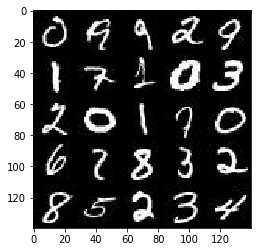

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

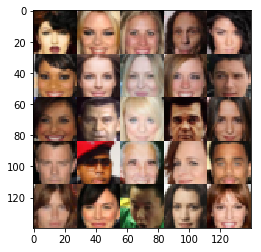

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [48]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [49]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 2x2x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [50]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x5 now
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [51]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [52]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # credit to angelmtenor for bringing attention to control_dependencies
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [58]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width, image_height, out_channel_dim = data_shape[1], data_shape[2], data_shape[3]
    input_real, input_z, l_rate = model_inputs(image_width, image_height, len(data_image_mode), z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate , 0.5)
    
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images.reshape(batch_size, image_width, image_height, out_channel_dim)
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers. Running generator twice to try to reduce generator loss
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate: learning_rate})
                
                
                
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    _ = show_generator_output(sess, 6, input_z, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.1272... Generator Loss: 0.0073
Epoch 1/2... Discriminator Loss: 3.4525... Generator Loss: 0.0514
Epoch 1/2... Discriminator Loss: 2.7912... Generator Loss: 0.1022
Epoch 1/2... Discriminator Loss: 2.2670... Generator Loss: 0.1735
Epoch 1/2... Discriminator Loss: 2.2028... Generator Loss: 0.1997


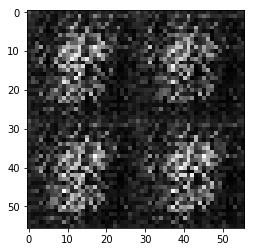

Epoch 1/2... Discriminator Loss: 1.5223... Generator Loss: 0.4215
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 0.4514
Epoch 1/2... Discriminator Loss: 1.0382... Generator Loss: 0.6883
Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 0.5312
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 0.6701


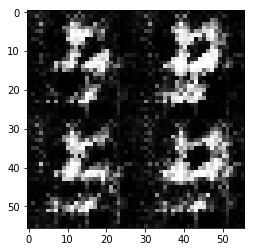

Epoch 1/2... Discriminator Loss: 1.0441... Generator Loss: 0.6304
Epoch 1/2... Discriminator Loss: 1.4348... Generator Loss: 0.5123
Epoch 1/2... Discriminator Loss: 1.2624... Generator Loss: 0.4492
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 0.5551
Epoch 1/2... Discriminator Loss: 2.6939... Generator Loss: 0.0773


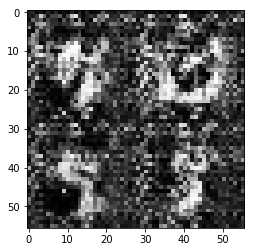

Epoch 1/2... Discriminator Loss: 2.1349... Generator Loss: 0.1899
Epoch 1/2... Discriminator Loss: 2.8472... Generator Loss: 0.1038
Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 0.4680
Epoch 1/2... Discriminator Loss: 1.4679... Generator Loss: 0.4658
Epoch 1/2... Discriminator Loss: 0.8551... Generator Loss: 0.8217


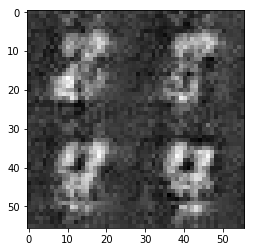

Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 0.7493... Generator Loss: 1.2274
Epoch 1/2... Discriminator Loss: 1.0515... Generator Loss: 0.5793
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 0.6097
Epoch 1/2... Discriminator Loss: 1.5405... Generator Loss: 0.2956


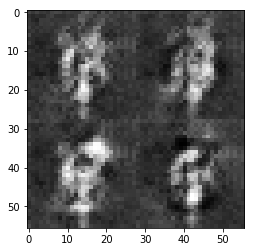

Epoch 1/2... Discriminator Loss: 0.5326... Generator Loss: 1.5206
Epoch 1/2... Discriminator Loss: 0.5430... Generator Loss: 1.2238
Epoch 1/2... Discriminator Loss: 0.7059... Generator Loss: 0.8752
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 0.8766
Epoch 1/2... Discriminator Loss: 0.9728... Generator Loss: 0.5881


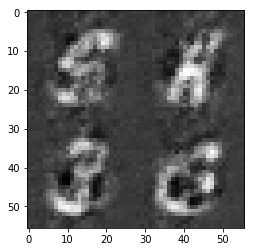

Epoch 1/2... Discriminator Loss: 0.8342... Generator Loss: 0.7256
Epoch 1/2... Discriminator Loss: 0.6910... Generator Loss: 0.9907
Epoch 1/2... Discriminator Loss: 0.8423... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 1.4745
Epoch 1/2... Discriminator Loss: 0.5724... Generator Loss: 1.0647


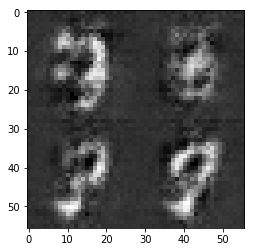

Epoch 1/2... Discriminator Loss: 0.8353... Generator Loss: 0.6774
Epoch 1/2... Discriminator Loss: 0.3529... Generator Loss: 2.2767
Epoch 1/2... Discriminator Loss: 0.7010... Generator Loss: 1.1335
Epoch 1/2... Discriminator Loss: 0.6184... Generator Loss: 1.2513
Epoch 1/2... Discriminator Loss: 0.8950... Generator Loss: 0.6690


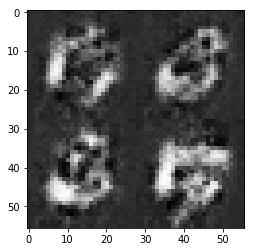

Epoch 1/2... Discriminator Loss: 0.5229... Generator Loss: 1.2089
Epoch 1/2... Discriminator Loss: 0.4945... Generator Loss: 1.2982
Epoch 1/2... Discriminator Loss: 0.7819... Generator Loss: 0.7053
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 0.4408
Epoch 1/2... Discriminator Loss: 1.4655... Generator Loss: 0.3011


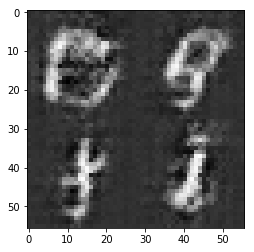

Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 0.5781
Epoch 1/2... Discriminator Loss: 0.7001... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 0.5025... Generator Loss: 1.0202
Epoch 1/2... Discriminator Loss: 0.6699... Generator Loss: 0.8607
Epoch 1/2... Discriminator Loss: 0.8351... Generator Loss: 0.6623


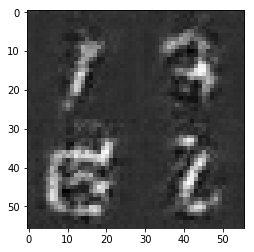

Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 0.7799
Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 0.5351
Epoch 1/2... Discriminator Loss: 0.8660... Generator Loss: 0.7097
Epoch 1/2... Discriminator Loss: 0.8748... Generator Loss: 0.6178
Epoch 1/2... Discriminator Loss: 0.6181... Generator Loss: 0.9317


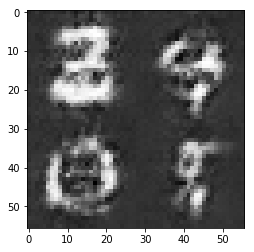

Epoch 1/2... Discriminator Loss: 0.2703... Generator Loss: 2.1404
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 0.4429
Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 0.5179
Epoch 1/2... Discriminator Loss: 0.8436... Generator Loss: 0.7775


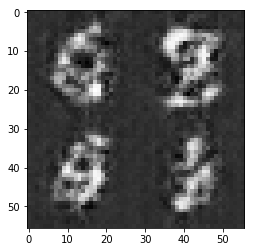

Epoch 1/2... Discriminator Loss: 0.5586... Generator Loss: 1.0837
Epoch 1/2... Discriminator Loss: 0.7566... Generator Loss: 0.7550
Epoch 1/2... Discriminator Loss: 0.7058... Generator Loss: 0.8869
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 0.8199
Epoch 1/2... Discriminator Loss: 0.2474... Generator Loss: 2.0652


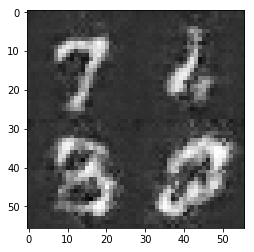

Epoch 1/2... Discriminator Loss: 0.5892... Generator Loss: 0.9459
Epoch 1/2... Discriminator Loss: 0.7610... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 0.9013
Epoch 1/2... Discriminator Loss: 0.3328... Generator Loss: 1.5326
Epoch 1/2... Discriminator Loss: 0.7665... Generator Loss: 0.6819


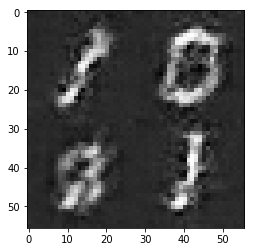

Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 0.6318
Epoch 1/2... Discriminator Loss: 0.3749... Generator Loss: 1.5035
Epoch 1/2... Discriminator Loss: 0.2341... Generator Loss: 1.8925
Epoch 1/2... Discriminator Loss: 0.3622... Generator Loss: 1.3996
Epoch 1/2... Discriminator Loss: 0.7836... Generator Loss: 0.7651


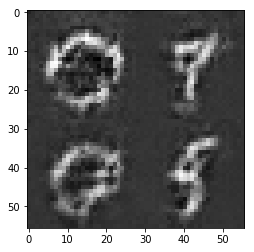

Epoch 1/2... Discriminator Loss: 0.2106... Generator Loss: 2.0577
Epoch 1/2... Discriminator Loss: 0.2085... Generator Loss: 2.3436
Epoch 1/2... Discriminator Loss: 0.3975... Generator Loss: 1.2233
Epoch 1/2... Discriminator Loss: 1.6006... Generator Loss: 0.4626
Epoch 1/2... Discriminator Loss: 0.5756... Generator Loss: 1.1320


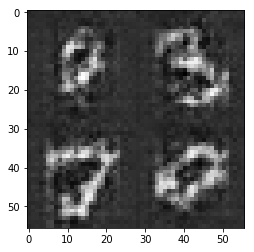

Epoch 1/2... Discriminator Loss: 0.4771... Generator Loss: 1.2354
Epoch 1/2... Discriminator Loss: 0.2308... Generator Loss: 1.8171
Epoch 1/2... Discriminator Loss: 0.0956... Generator Loss: 2.9930
Epoch 1/2... Discriminator Loss: 0.9002... Generator Loss: 0.6785
Epoch 1/2... Discriminator Loss: 0.4125... Generator Loss: 1.4384


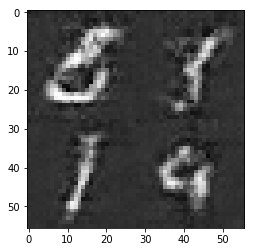

Epoch 1/2... Discriminator Loss: 0.3095... Generator Loss: 1.6055
Epoch 1/2... Discriminator Loss: 0.4189... Generator Loss: 1.2399
Epoch 1/2... Discriminator Loss: 0.1757... Generator Loss: 2.1354
Epoch 1/2... Discriminator Loss: 0.4829... Generator Loss: 1.1419
Epoch 1/2... Discriminator Loss: 0.7678... Generator Loss: 0.7406


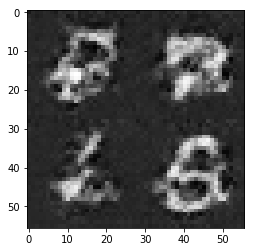

Epoch 1/2... Discriminator Loss: 0.2751... Generator Loss: 1.6283
Epoch 1/2... Discriminator Loss: 0.4480... Generator Loss: 1.2130
Epoch 1/2... Discriminator Loss: 0.1058... Generator Loss: 2.9029
Epoch 2/2... Discriminator Loss: 0.0537... Generator Loss: 3.7965
Epoch 2/2... Discriminator Loss: 0.1705... Generator Loss: 2.0250


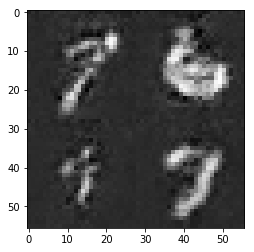

Epoch 2/2... Discriminator Loss: 0.3228... Generator Loss: 1.4601
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 0.5955
Epoch 2/2... Discriminator Loss: 0.2496... Generator Loss: 1.8606
Epoch 2/2... Discriminator Loss: 0.0818... Generator Loss: 3.9916
Epoch 2/2... Discriminator Loss: 1.8362... Generator Loss: 0.2297


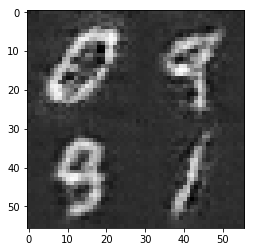

Epoch 2/2... Discriminator Loss: 0.1819... Generator Loss: 2.3542
Epoch 2/2... Discriminator Loss: 0.3979... Generator Loss: 1.3743
Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 0.7593
Epoch 2/2... Discriminator Loss: 0.4053... Generator Loss: 1.3445
Epoch 2/2... Discriminator Loss: 0.1392... Generator Loss: 2.5037


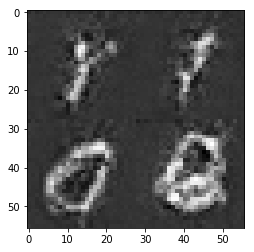

Epoch 2/2... Discriminator Loss: 0.5645... Generator Loss: 1.0708
Epoch 2/2... Discriminator Loss: 0.2427... Generator Loss: 1.6645
Epoch 2/2... Discriminator Loss: 0.4469... Generator Loss: 1.1059
Epoch 2/2... Discriminator Loss: 0.4779... Generator Loss: 1.2765
Epoch 2/2... Discriminator Loss: 0.9803... Generator Loss: 0.6285


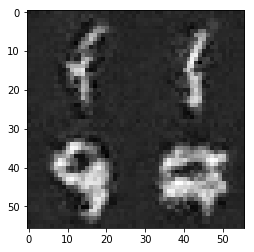

Epoch 2/2... Discriminator Loss: 0.1756... Generator Loss: 2.2424
Epoch 2/2... Discriminator Loss: 0.1080... Generator Loss: 2.6373
Epoch 2/2... Discriminator Loss: 0.4484... Generator Loss: 1.2511
Epoch 2/2... Discriminator Loss: 1.9609... Generator Loss: 0.1630
Epoch 2/2... Discriminator Loss: 10.5035... Generator Loss: 13.0916


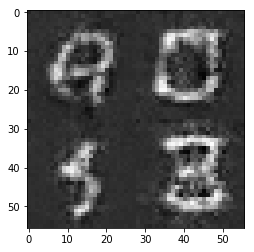

Epoch 2/2... Discriminator Loss: 0.9881... Generator Loss: 0.5736
Epoch 2/2... Discriminator Loss: 0.1452... Generator Loss: 3.3003
Epoch 2/2... Discriminator Loss: 0.8768... Generator Loss: 0.7002
Epoch 2/2... Discriminator Loss: 0.4651... Generator Loss: 1.1218
Epoch 2/2... Discriminator Loss: 0.2096... Generator Loss: 2.0965


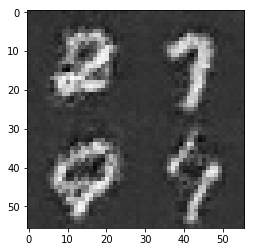

Epoch 2/2... Discriminator Loss: 0.1045... Generator Loss: 2.9591
Epoch 2/2... Discriminator Loss: 0.1801... Generator Loss: 2.0081
Epoch 2/2... Discriminator Loss: 0.1817... Generator Loss: 2.3440
Epoch 2/2... Discriminator Loss: 0.0693... Generator Loss: 3.2002
Epoch 2/2... Discriminator Loss: 0.4391... Generator Loss: 1.1680


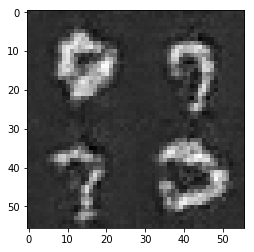

Epoch 2/2... Discriminator Loss: 0.2683... Generator Loss: 1.7171
Epoch 2/2... Discriminator Loss: 0.3055... Generator Loss: 1.4248
Epoch 2/2... Discriminator Loss: 0.6876... Generator Loss: 1.0468
Epoch 2/2... Discriminator Loss: 0.4246... Generator Loss: 1.7577
Epoch 2/2... Discriminator Loss: 0.3542... Generator Loss: 1.7620


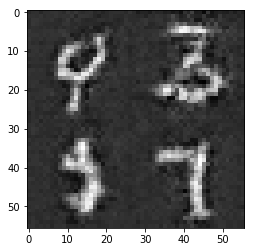

Epoch 2/2... Discriminator Loss: 0.0824... Generator Loss: 3.7668
Epoch 2/2... Discriminator Loss: 0.4808... Generator Loss: 1.1328
Epoch 2/2... Discriminator Loss: 0.3129... Generator Loss: 1.5616
Epoch 2/2... Discriminator Loss: 0.1440... Generator Loss: 2.3387
Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 0.6690


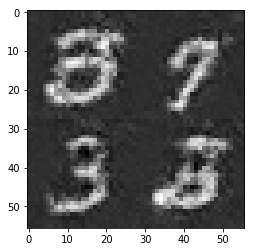

Epoch 2/2... Discriminator Loss: 0.9983... Generator Loss: 2.6254
Epoch 2/2... Discriminator Loss: 0.8002... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 0.6893
Epoch 2/2... Discriminator Loss: 0.7659... Generator Loss: 0.7595
Epoch 2/2... Discriminator Loss: 0.2205... Generator Loss: 1.9206


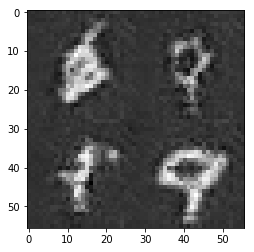

Epoch 2/2... Discriminator Loss: 0.2873... Generator Loss: 1.6277
Epoch 2/2... Discriminator Loss: 0.1360... Generator Loss: 2.3843
Epoch 2/2... Discriminator Loss: 0.4858... Generator Loss: 1.2406
Epoch 2/2... Discriminator Loss: 0.2243... Generator Loss: 1.6987
Epoch 2/2... Discriminator Loss: 0.2010... Generator Loss: 2.2285


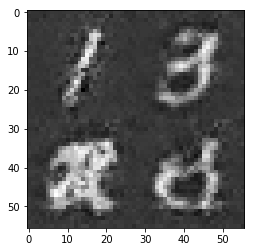

Epoch 2/2... Discriminator Loss: 0.3173... Generator Loss: 1.5342
Epoch 2/2... Discriminator Loss: 0.1746... Generator Loss: 2.2687
Epoch 2/2... Discriminator Loss: 0.1996... Generator Loss: 1.9678
Epoch 2/2... Discriminator Loss: 0.0362... Generator Loss: 3.6168
Epoch 2/2... Discriminator Loss: 0.3374... Generator Loss: 1.4080


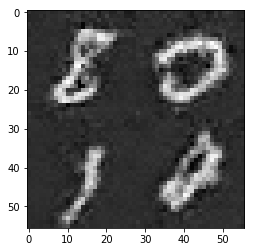

Epoch 2/2... Discriminator Loss: 0.2195... Generator Loss: 1.8701
Epoch 2/2... Discriminator Loss: 0.2279... Generator Loss: 1.8188
Epoch 2/2... Discriminator Loss: 0.3429... Generator Loss: 1.5284
Epoch 2/2... Discriminator Loss: 0.0880... Generator Loss: 2.7860
Epoch 2/2... Discriminator Loss: 1.7731... Generator Loss: 0.2631


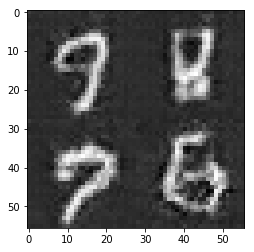

Epoch 2/2... Discriminator Loss: 0.4538... Generator Loss: 1.3669
Epoch 2/2... Discriminator Loss: 0.4687... Generator Loss: 1.7383
Epoch 2/2... Discriminator Loss: 0.2090... Generator Loss: 2.3247
Epoch 2/2... Discriminator Loss: 0.2654... Generator Loss: 1.8891
Epoch 2/2... Discriminator Loss: 0.1541... Generator Loss: 2.1082


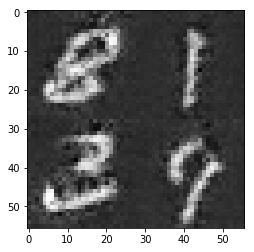

Epoch 2/2... Discriminator Loss: 0.9003... Generator Loss: 0.7264
Epoch 2/2... Discriminator Loss: 1.0977... Generator Loss: 0.4813
Epoch 2/2... Discriminator Loss: 0.3416... Generator Loss: 1.5793
Epoch 2/2... Discriminator Loss: 0.0397... Generator Loss: 3.6287
Epoch 2/2... Discriminator Loss: 0.4431... Generator Loss: 1.3220


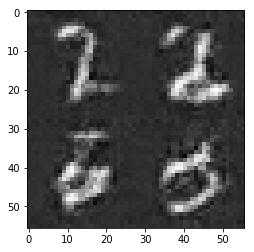

Epoch 2/2... Discriminator Loss: 0.0202... Generator Loss: 4.5651
Epoch 2/2... Discriminator Loss: 0.3870... Generator Loss: 1.3682
Epoch 2/2... Discriminator Loss: 0.1554... Generator Loss: 2.3070
Epoch 2/2... Discriminator Loss: 0.5055... Generator Loss: 1.1171
Epoch 2/2... Discriminator Loss: 0.1979... Generator Loss: 2.1376


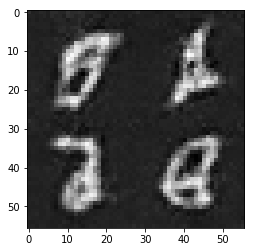

Epoch 2/2... Discriminator Loss: 1.6271... Generator Loss: 0.4301
Epoch 2/2... Discriminator Loss: 0.3682... Generator Loss: 1.5852
Epoch 2/2... Discriminator Loss: 1.1070... Generator Loss: 0.6153
Epoch 2/2... Discriminator Loss: 0.3643... Generator Loss: 2.3462
Epoch 2/2... Discriminator Loss: 0.9298... Generator Loss: 0.5722


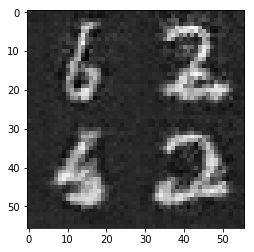

Epoch 2/2... Discriminator Loss: 0.1560... Generator Loss: 2.2856
Epoch 2/2... Discriminator Loss: 0.6030... Generator Loss: 0.9595
Epoch 2/2... Discriminator Loss: 0.1197... Generator Loss: 2.5504
Epoch 2/2... Discriminator Loss: 0.4746... Generator Loss: 1.6632
Epoch 2/2... Discriminator Loss: 0.4933... Generator Loss: 1.5925


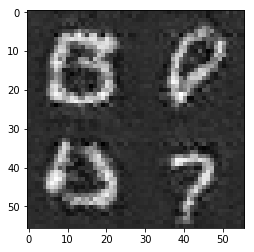

Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 0.2337... Generator Loss: 2.0464
Epoch 2/2... Discriminator Loss: 0.4395... Generator Loss: 1.5046
Epoch 2/2... Discriminator Loss: 0.5083... Generator Loss: 1.1920
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 0.5859


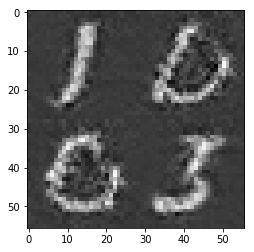

Epoch 2/2... Discriminator Loss: 0.9403... Generator Loss: 0.6611
Epoch 2/2... Discriminator Loss: 0.0309... Generator Loss: 4.3564


In [59]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.8123... Generator Loss: 0.0014
Epoch 1/1... Discriminator Loss: 4.8810... Generator Loss: 0.0089
Epoch 1/1... Discriminator Loss: 3.5250... Generator Loss: 0.0370
Epoch 1/1... Discriminator Loss: 2.5584... Generator Loss: 0.1045
Epoch 1/1... Discriminator Loss: 1.9957... Generator Loss: 0.2059


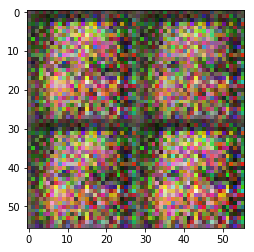

Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.4300
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 0.6385... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 1.0739


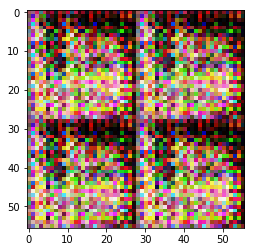

Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 1.4014
Epoch 1/1... Discriminator Loss: 0.2777... Generator Loss: 1.5948
Epoch 1/1... Discriminator Loss: 0.2238... Generator Loss: 1.8528
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 1.5437


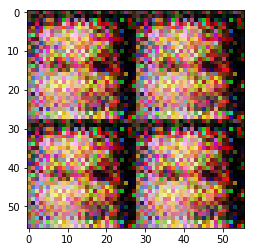

Epoch 1/1... Discriminator Loss: 0.2234... Generator Loss: 2.4679
Epoch 1/1... Discriminator Loss: 0.1394... Generator Loss: 2.3571
Epoch 1/1... Discriminator Loss: 0.2955... Generator Loss: 2.9849
Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 1.6244
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 1.5423


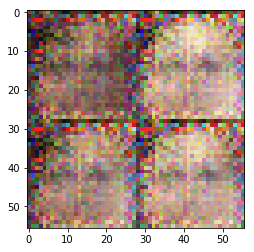

Epoch 1/1... Discriminator Loss: 2.3045... Generator Loss: 0.2130
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 2.0604... Generator Loss: 0.3198
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 0.8897


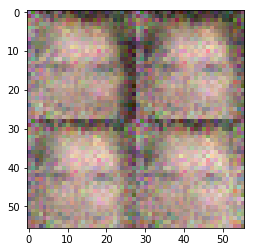

Epoch 1/1... Discriminator Loss: 1.8071... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.6900... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.6412


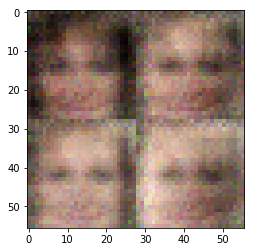

Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.5388


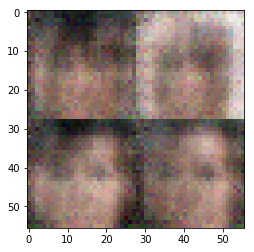

Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7088


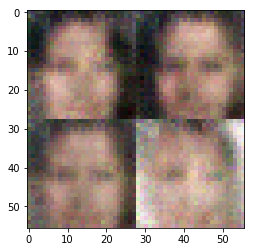

Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.6420


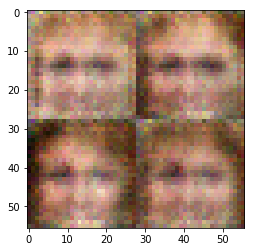

Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.8047


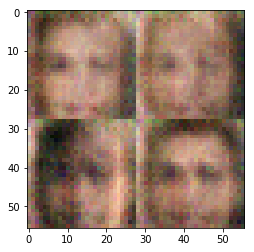

Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.8137


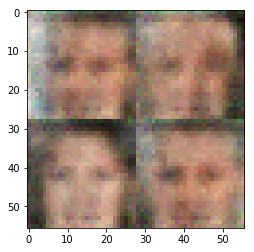

Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6422


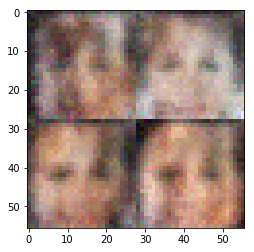

Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7357


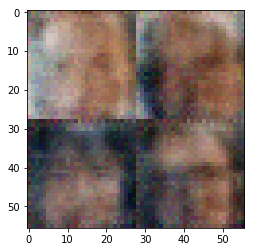

Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.5316


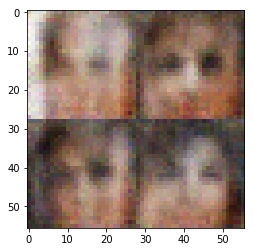

Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.6728


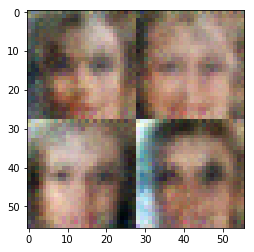

Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.7500... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 1.5978... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.4945


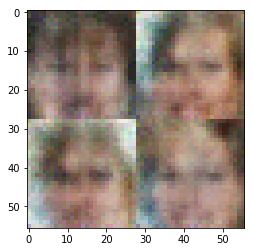

Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.6140... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.6424... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6319


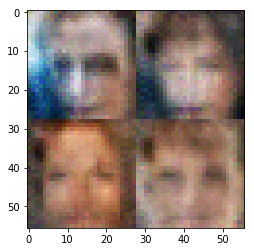

Epoch 1/1... Discriminator Loss: 1.6792... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.5980


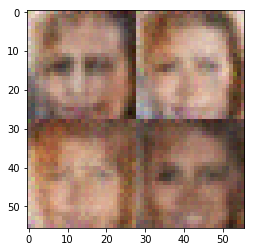

Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.4724


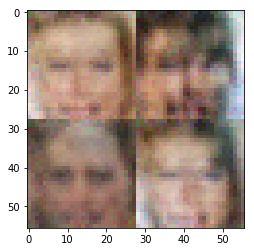

Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.5826... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.5583


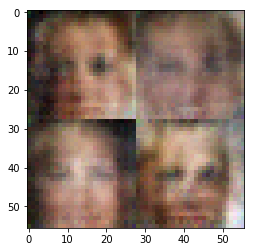

Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.6143... Generator Loss: 0.5110


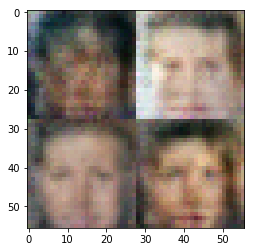

Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.6746


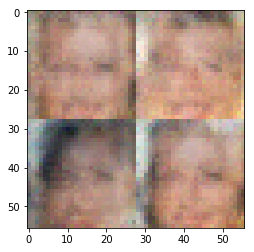

Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6983


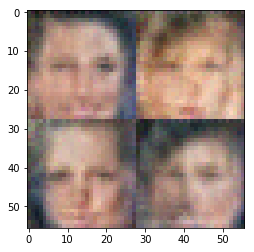

Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.6563... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.6473


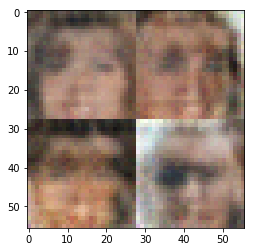

Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.5652


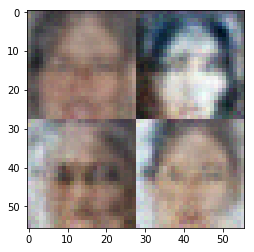

Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.7910... Generator Loss: 0.4134
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6492


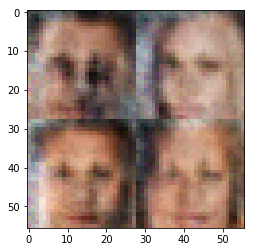

Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.6216... Generator Loss: 0.5215
Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 0.5687


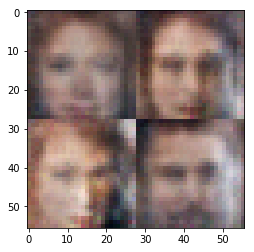

Epoch 1/1... Discriminator Loss: 1.6772... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.6497... Generator Loss: 0.5241


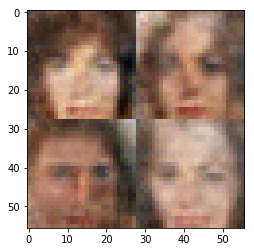

Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.5622


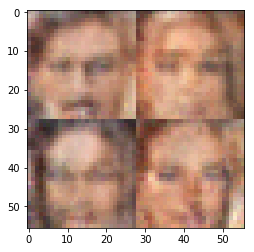

Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.7743... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.5324


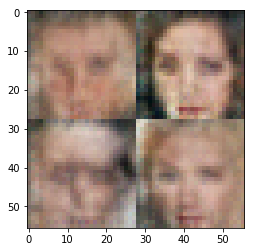

Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.4572


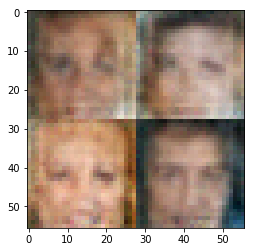

Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.7800... Generator Loss: 0.4721
Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.6321... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.5595


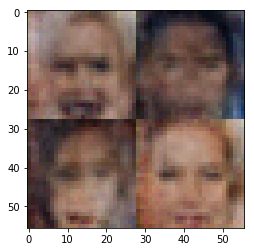

Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.5670
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 0.4558


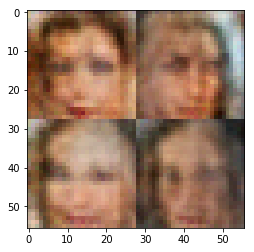

Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.7370... Generator Loss: 0.4322
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.4410


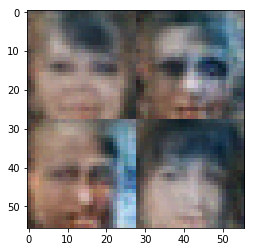

Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.5681


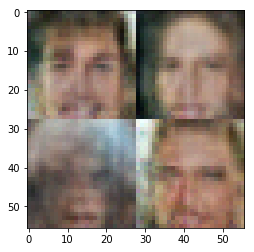

Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 1.7300... Generator Loss: 0.4190
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.5733... Generator Loss: 0.4079
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.4362


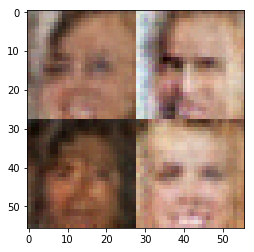

Epoch 1/1... Discriminator Loss: 1.6249... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.3885


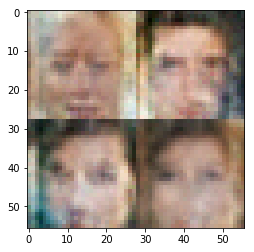

Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.7357... Generator Loss: 0.3524
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.4260
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.3964


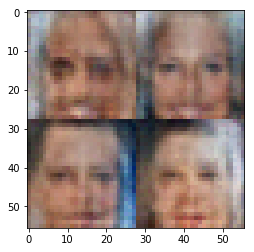

Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.6392... Generator Loss: 0.4571
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.4156
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.6517


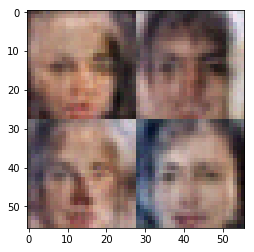

Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.4298


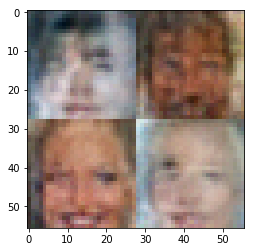

Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.5113


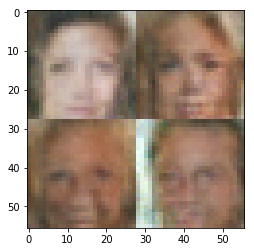

Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.4350
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.4473
Epoch 1/1... Discriminator Loss: 1.6847... Generator Loss: 0.3264
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.4123


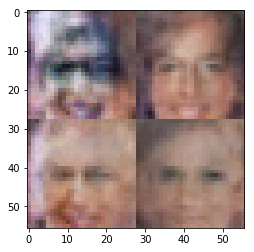

Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.3624
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.6382


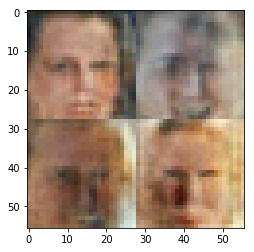

Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.4347
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.6605... Generator Loss: 0.4142
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.9723


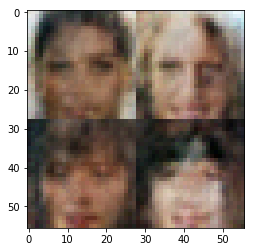

Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.4985
Epoch 1/1... Discriminator Loss: 1.6919... Generator Loss: 0.4322
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.7660


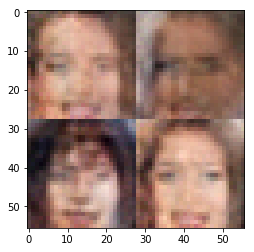

Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.4146
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 1.1688
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.6034... Generator Loss: 0.3447


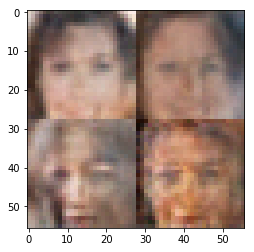

Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.3904
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 0.3749


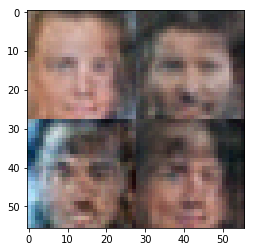

Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.4202
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.6023... Generator Loss: 0.3961


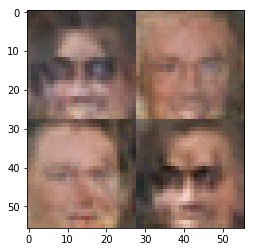

Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.3286
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.5321


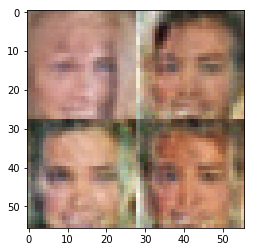

Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.3485
Epoch 1/1... Discriminator Loss: 1.8207... Generator Loss: 0.3034
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.8932


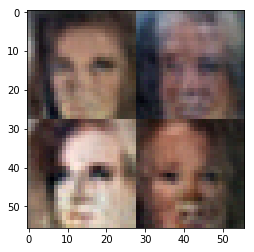

Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.5885... Generator Loss: 0.3800
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.7905


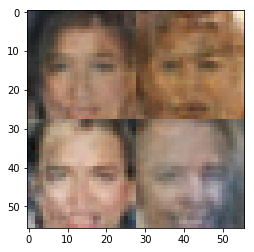

Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.4124


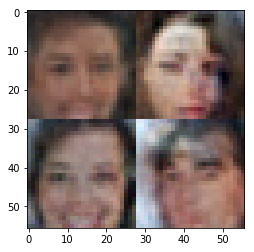

Epoch 1/1... Discriminator Loss: 1.6200... Generator Loss: 0.2821
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.5985... Generator Loss: 0.3248
Epoch 1/1... Discriminator Loss: 1.7271... Generator Loss: 0.2663
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.8304


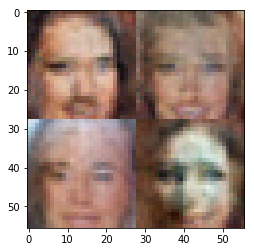

Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.5213


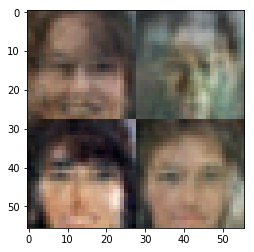

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.4363
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.4045
Epoch 1/1... Discriminator Loss: 1.6490... Generator Loss: 0.3509
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.5556


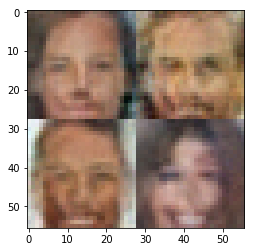

Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.8731... Generator Loss: 0.3054
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.4393


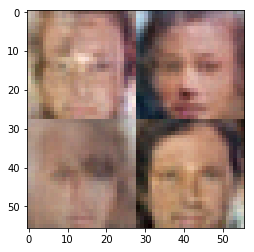

Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 0.9426


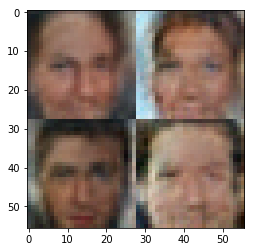

Epoch 1/1... Discriminator Loss: 2.0174... Generator Loss: 0.1840
Epoch 1/1... Discriminator Loss: 1.7527... Generator Loss: 0.2844
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.1870


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.